# Q1. 
Take the MNIST dataset and sample 20000 images from the training dataset. Convert
the single channel images into 3 channel images by adding two more duplicate layers of
the respective images to itself. Run a CNN autoencoder to generate the single channel
images from the 3 channel images.

In [117]:
# Importing modules

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
# from torchvision import transforms, datasets
# import PIL
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np

device = torch.device('cuda')

In [118]:
# Loading Data
!wget https://github.com/MorvanZhou/PyTorch-Tutorial/raw/master/tutorial-contents-notebooks/mnist/processed/training.pt

--2021-10-29 09:30:45--  https://github.com/MorvanZhou/PyTorch-Tutorial/raw/master/tutorial-contents-notebooks/mnist/processed/training.pt
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MorvanZhou/PyTorch-Tutorial/master/tutorial-contents-notebooks/mnist/processed/training.pt [following]
--2021-10-29 09:30:45--  https://raw.githubusercontent.com/MorvanZhou/PyTorch-Tutorial/master/tutorial-contents-notebooks/mnist/processed/training.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47520431 (45M) [application/octet-stream]
Saving to: ‘training.pt.2’

training.pt.2       100%[===================

In [119]:
# Loading data
x_train, _ = torch.load('training.pt')
x_train = x_train.float()
x_train.shape

torch.Size([60000, 28, 28])

In [120]:
# Making a copy of x_train. Will be used as target later
from copy import deepcopy
y_train = deepcopy(x_train)
y_train.size()

torch.Size([60000, 28, 28])

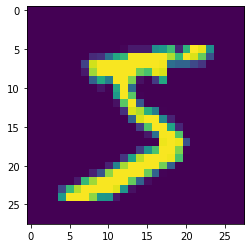

In [121]:
plt.imshow(x_train[0])
plt.show()

In [122]:
# Adding 2 more layers of same image to create 3 channel image
x_train = x_train.view(60000,1,28,28)
print(x_train.size())
x_train = torch.cat((x_train,x_train,x_train),dim=1,)
print(x_train.size())

torch.Size([60000, 1, 28, 28])
torch.Size([60000, 3, 28, 28])


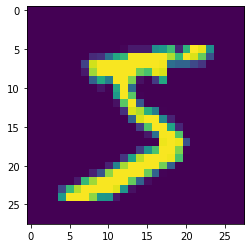

In [123]:
plt.imshow(x_train[0][1])
plt.show()

In [124]:
# Reshaping x_train before fedding to network
x_train = x_train.reshape(-1,3*28*28)  # Important. Do this here and not inside loop i.e. (batch.reshape(..))
y_train = y_train.reshape(-1,28*28)  # Important. Do this here and not inside loop i.e. (batch.reshape(..))

print(x_train.size())
train_data_loader = DataLoader(TensorDataset(x_train,y_train),batch_size=512, shuffle=True)
for batch,target in train_data_loader:
    print(batch.size(),target.size())  # Should be 3*28*28=2352 and 28*28=784
    break

torch.Size([60000, 2352])
torch.Size([512, 2352]) torch.Size([512, 784])


In [125]:
class autoEncode(nn.Module):

    def __init__(self):

        """
        constructor of class
        3 layers in encoder and 3 layers in decoder
        """
        super(autoEncode, self).__init__()
        # self.bn1 = nn.BatchNorm2d(num_features=3*28*28)
        self.en_fc1 = nn.Linear(in_features=3*28*28,out_features=128)
        self.en_fc2 = nn.Linear(in_features=128,out_features=256)
        self.en_fc3 = nn.Linear(in_features=256,out_features=25)

        self.de_fc1 = nn.Linear(in_features=25,out_features=256)
        self.de_fc2 = nn.Linear(in_features=256,out_features=128)
        self.de_fc3 = nn.Linear(in_features=128,out_features=28*28)


    def encoder(self,x):

        """
        encoder function
        """

        x = self.en_fc1(x)
        x = F.relu(x)
        x= self.en_fc2(x)
        x = F.relu(x)
        x= self.en_fc3(x)
        x = F.relu(x)

        return x

    
    def decoder(self,x):

        """
        decoder function
        """

        x = self.de_fc1(x)
        x = F.relu(x)
        x= self.de_fc2(x)
        x = F.relu(x)
        x= self.de_fc3(x)
        x = F.relu(x)

        return x 

    def forward(self,x):
        
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [126]:
device = torch.device('cuda')
try:
    del model
except:
    print('No model found')
else:
    print('model deleted')
finally:
    model = autoEncode()
    model = model.to(device)
    print('model instantiated')

model deleted
model instantiated


In [127]:
opt = Adam(model.parameters(), lr=0.001)

In [128]:
# Function to carry out training

def train(model:nn.Module,
          data_loader:DataLoader,
          optimizer = torch.optim.Optimizer):
    
    model.train()
    training_loss = 0.0
    for batch,target in data_loader:
        batch = batch.to(device)
        target = target.to(device)

        out = model(batch)
        loss = F.mse_loss(out/255,target/255)
        loss.backward()
        opt.step()
        opt.zero_grad()

        training_loss += loss.item()

    return training_loss

In [129]:
# Training auto encoder

tq = tqdm(range(300))  # training for 300 epochs

training_loss = []

desc = 0
for epoch in tq:
    tq.set_description(desc=f'training loss {desc}     |')
    t_loss = train(model=model,data_loader=train_data_loader, optimizer=opt)
    training_loss.append(t_loss)
    desc = t_loss
    if (epoch+1) in [5,10,15,20,25,50,55,75,105,250,300,400,550,600,750,800,850,900,950,1000,1100,1200,1300,1500,1700,1800,1950,2000]:
        print('epoch: ',epoch+1, 'training_loss: ',training_loss[epoch])

  0%|          | 0/300 [00:00<?, ?it/s]

epoch:  5 training_loss:  2.624269103631377
epoch:  10 training_loss:  2.3206730857491493
epoch:  15 training_loss:  2.195180846378207
epoch:  20 training_loss:  2.1191037595272064
epoch:  25 training_loss:  2.061743412166834
epoch:  50 training_loss:  1.8927278649061918
epoch:  55 training_loss:  1.8703487068414688
epoch:  75 training_loss:  1.793236662633717
epoch:  105 training_loss:  1.7326642563566566
epoch:  250 training_loss:  1.5861841347068548
epoch:  300 training_loss:  1.5612758779898286


torch.Size([60000, 784])


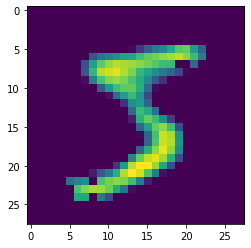

In [130]:
# Looking into the output of model
output = model(x_train.to(device)) # Prediction by model or model output
print(output.size())

output = output.detach().cpu().numpy()
plt.imshow(output[0].reshape(28,28))
plt.show()

# Q2
Try to build a neural network which will take images of number one from the MNIST
training data and produce image of number two.

In [131]:
torch.cuda.empty_cache()

In [132]:
del model, opt, x_train, y_train,train_data_loader

In [133]:
!wget https://github.com/MorvanZhou/PyTorch-Tutorial/raw/master/tutorial-contents-notebooks/mnist/processed/training.pt

--2021-10-29 09:38:10--  https://github.com/MorvanZhou/PyTorch-Tutorial/raw/master/tutorial-contents-notebooks/mnist/processed/training.pt
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MorvanZhou/PyTorch-Tutorial/master/tutorial-contents-notebooks/mnist/processed/training.pt [following]
--2021-10-29 09:38:11--  https://raw.githubusercontent.com/MorvanZhou/PyTorch-Tutorial/master/tutorial-contents-notebooks/mnist/processed/training.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47520431 (45M) [application/octet-stream]
Saving to: ‘training.pt.3’

training.pt.3       100%[===================

In [134]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
# from torchvision import transforms, datasets
# import PIL
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np

device = torch.device('cuda')

In [135]:
x_train, y_train = torch.load('training.pt')
x_train = x_train.float()

In [136]:
idx_1 = torch.where(y_train == 1)[0]
idx_2 = torch.where(y_train == 2)[0]

x_t = x_train[idx_1] # predictor
y_t = x_train[idx_2] # target

# Making number of observation in predictor and target equal
if len(idx_1) < len(idx_2):
    y_t = y_t[:len(idx_1)]
else:
    x_t = x_t[:len(idx_2)]

In [137]:
x_t.size(),y_t.size()

(torch.Size([5958, 28, 28]), torch.Size([5958, 28, 28]))

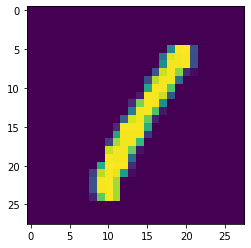

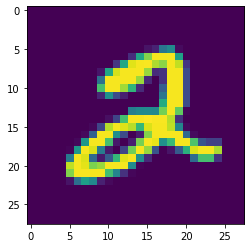

In [138]:
plt.imshow(x_t[0])
plt.show()

plt.imshow(y_t[0])
plt.show()

In [139]:
x_t = x_t.reshape(-1,28*28)  # Important. Do this here and not inside loop i.e. (batch.reshape(..))
y_t = y_t.reshape(-1,28*28)  # Important. Do this here and not inside loop i.e. (batch.reshape(..))

In [140]:
train_data_loader = DataLoader(TensorDataset(x_t,y_t),batch_size=512, shuffle=True)
for batch,target in train_data_loader:
    print(batch.size(),target.size())  # Should be 28*28=784 and 28*28=784
    break

torch.Size([512, 784]) torch.Size([512, 784])


In [141]:
class autoEncode(nn.Module):

    def __init__(self):

        super(autoEncode, self).__init__()
        # self.bn1 = nn.BatchNorm2d(num_features=3*28*28)
        self.en_fc1 = nn.Linear(in_features=28*28,out_features=128)
        self.en_fc2 = nn.Linear(in_features=128,out_features=256)
        self.en_fc3 = nn.Linear(in_features=256,out_features=25)

        self.de_fc1 = nn.Linear(in_features=25,out_features=256)
        self.de_fc2 = nn.Linear(in_features=256,out_features=128)
        self.de_fc3 = nn.Linear(in_features=128,out_features=28*28)


    def encoder(self,x):

        x = self.en_fc1(x)
        x = F.relu(x)
        x= self.en_fc2(x)
        x = F.relu(x)
        x= self.en_fc3(x)
        x = F.relu(x)

        return x

    
    def decoder(self,x):

        x = self.de_fc1(x)
        x = F.relu(x)
        x= self.de_fc2(x)
        x = F.relu(x)
        x= self.de_fc3(x)
        x = F.relu(x)

        return x 

    def forward(self,x):

        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [142]:
device = torch.device('cuda')
try:
    del model
except:
    print('No model found')
else:
    print('model deleted')
finally:
    model = autoEncode()
    model = model.to(device)
    print('model instantiated')

No model found
model instantiated


In [143]:
opt = Adam(model.parameters(), lr=0.001)

In [144]:
# Training function
def train(model:nn.Module,
          data_loader:DataLoader,
          optimizer = torch.optim.Optimizer):
    
    model.train()
    training_loss = 0.0
    for batch,target in data_loader:
        batch = batch.to(device)
        target = target.to(device)

        out = model(batch)
        loss = F.mse_loss(out/255,target/255)
        loss.backward()
        opt.step()
        opt.zero_grad()

        training_loss += loss.item()

    return training_loss

In [145]:
tq = tqdm(range(350)) # Training for 350 epochs

training_loss = []

desc = 0
for epoch in tq:
    tq.set_description(desc=f'training loss {desc}     |')
    t_loss = train(model=model,data_loader=train_data_loader, optimizer=opt)
    training_loss.append(t_loss)
    desc = t_loss
    if (epoch+1) in [5,10,15,20,25,50,55,75,105,250,300,400,550,600,750,800,850,900,950,1000,1100,1200,1300,1500,1700,1800,1950,2000]:
        print('epoch: ',epoch+1, 'training_loss: ',training_loss[epoch])

  0%|          | 0/350 [00:00<?, ?it/s]

epoch:  5 training_loss:  0.9242249950766563
epoch:  10 training_loss:  0.9175471886992455
epoch:  15 training_loss:  0.9161640927195549
epoch:  20 training_loss:  0.913067415356636
epoch:  25 training_loss:  0.9115711599588394
epoch:  50 training_loss:  0.9059146270155907
epoch:  55 training_loss:  0.8994143009185791
epoch:  75 training_loss:  0.8422797173261642
epoch:  105 training_loss:  0.8011621460318565
epoch:  250 training_loss:  0.5553793832659721
epoch:  300 training_loss:  0.5033101364970207


torch.Size([5958, 784])


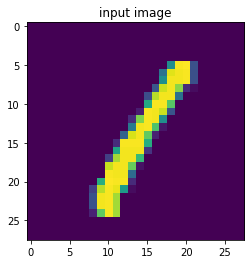

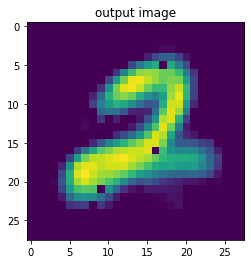

In [147]:
output = model(x_t.to(device))  # Model output
print(output.size())
output = output.detach().cpu().numpy()

plt.imshow(x_t[0].detach().cpu().numpy().reshape(28,28))
plt.title('input image')
plt.show()

plt.imshow(output[0].reshape(28,28))
plt.title('output image')

plt.show()